In [128]:
#! pip install wordcloud

In [129]:
#general utilities
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re
from nltk.tokenize import TweetTokenizer
import nltk
from collections import Counter
import plotly.graph_objects as go
from wordcloud import WordCloud

In [130]:
#tokenization resources
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [131]:
#for NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

In [132]:
#for coherence implementation
from gensim.models import Word2Vec
from itertools import combinations
from operator import itemgetter

In [133]:
#! pip install octis

In [134]:
#for topic diveristy
from octis.evaluation_metrics.diversity_metrics import TopicDiversity

In [135]:
#! pip install umap-learn
#! pip install hdbscan
#! pip install BERTopic

In [136]:
# for BERTopic
from sentence_transformers import SentenceTransformer
import umap as UMAP #https://github.com/MaartenGr/BERTopic/issues/723
from hdbscan import HDBSCAN
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
import plotly.io as pio

### Data Cleaning & EDA

Our dataset is a collection of 18,000 newsgroup documents from 20 different newgroups. The dataset has been split into training and testing subsets. We will be training our topic model on the larger subset, the training set. Since our algorithm is an unsupervised machine learning algorithm, we will not be using the test set. Additionally, the target values for the 20 different newsgroups will be used to assess the evaluation of our model in correctly extracting relevant topics.

In [137]:
# import dataset from sklearn

from sklearn.datasets import fetch_20newsgroups
dataset = fetch_20newsgroups(subset='train')

The data is split into document contents and targets. The 20 newsgroup targets are show below.

In [138]:
dataset.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

An example of a document and its corresponding newsgroup is illustrated. _Data_ includes the content of the newsgroup document, _target_ includes the index of the category of the newsgroup, and _target_names_ includes the name of the category of the newsgroup.

In [139]:
dataset.data[0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

In [140]:
dataset.target[0], dataset.target_names[dataset.target[0]]

(7, 'rec.autos')

We can represent this data as a dataframe for more efficient data cleaning and data exploration.

In [141]:
newsgroup_df = pd.DataFrame({"document": dataset.data, "target": dataset.target})
newsgroup_df = newsgroup_df.assign(newsgroup=newsgroup_df["target"].apply(lambda x: dataset.target_names[x]))
newsgroup_df.head()

document  target  \
0  From: lerxst@wam.umd.edu (where's my thing)\nS...       7   
1  From: guykuo@carson.u.washington.edu (Guy Kuo)...       4   
2  From: twillis@ec.ecn.purdue.edu (Thomas E Will...       4   
3  From: jgreen@amber (Joe Green)\nSubject: Re: W...       1   
4  From: jcm@head-cfa.harvard.edu (Jonathan McDow...      14   

               newsgroup  
0              rec.autos  
1  comp.sys.mac.hardware  
2  comp.sys.mac.hardware  
3          comp.graphics  
4              sci.space

Let's do some exploratory data analysis to better understand our dataset. First, we can look at the distribution of our newsgroup targets to see if there are any outliers.

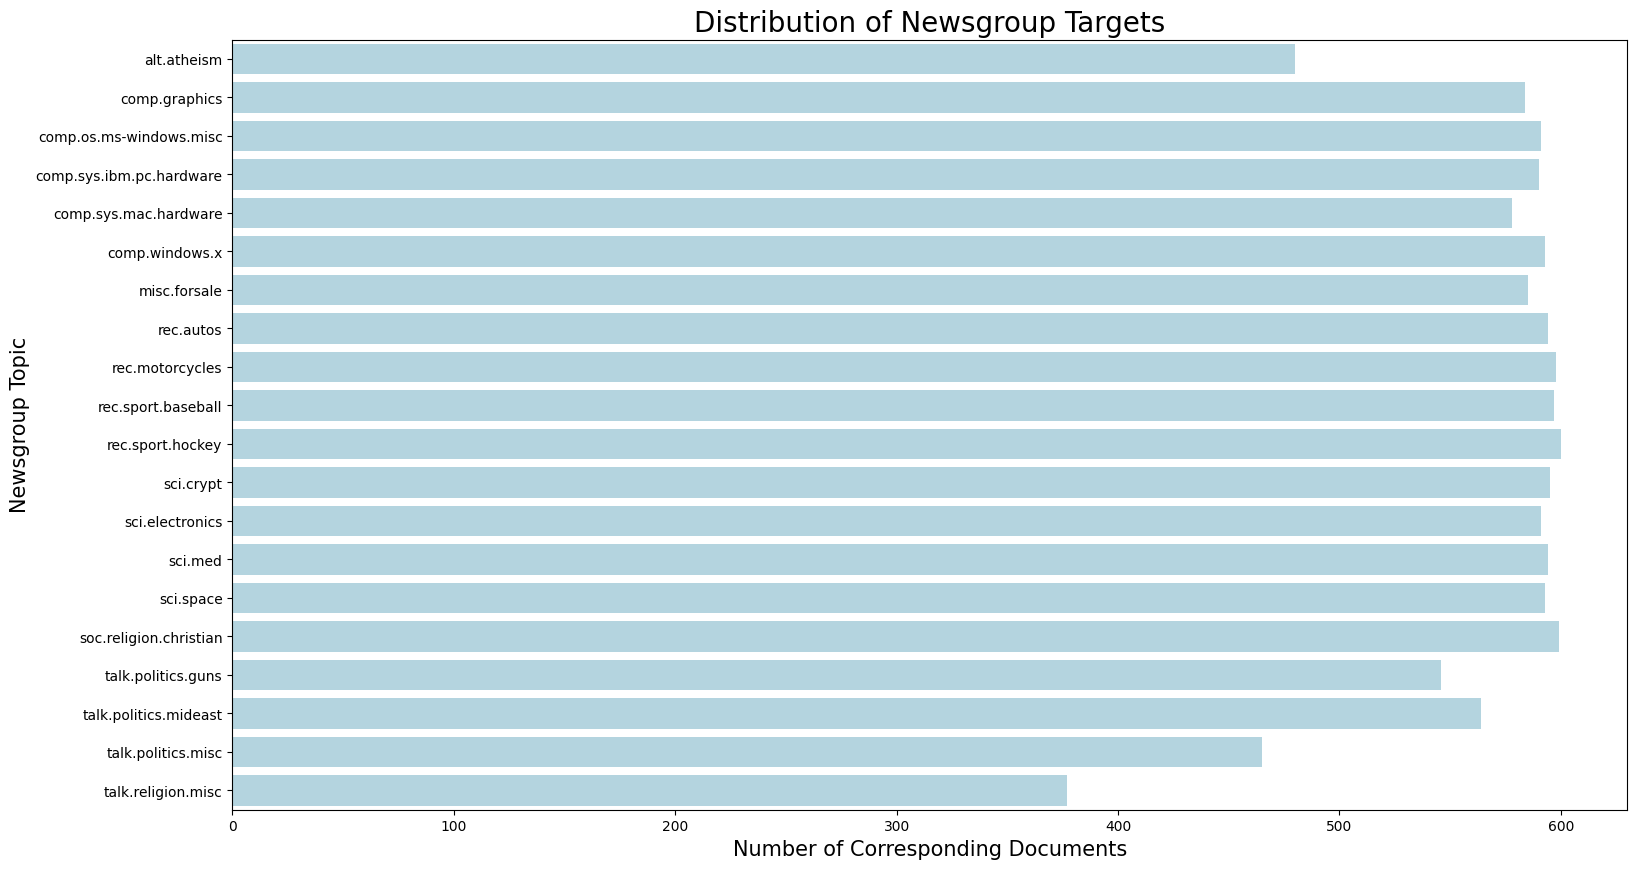

In [142]:
# plot the distribution of the newsgroups
fig1 = plt.figure(figsize =[18 ,10])
ax = sns.countplot(y=newsgroup_df['newsgroup'], color="lightblue", order=dataset.target_names)
plt.title('Distribution of Newsgroup Targets', size=20)
plt.ylabel('Newsgroup Topic', size = 15)
plt.xlabel('Number of Corresponding Documents', size = 15)
plt.show()

Some of the topics overlap in terms of abstract concepts, such as "alt.atheism" and "soc.religion.christian". We are interested in seeing how topic modeling is able to extract different themes from a wide range of subjects, so we will only look at a subset of 10 unique topics that share minimal overlap. These topics are: graphics, sale, motorcycles, hockey, cryptography, medical, space, religion, guns, and middle east politics.

In [143]:
# obtain a subset of the original data; only include 10 diverse topics
newsgroup_df = newsgroup_df[newsgroup_df["newsgroup"].isin([
    "comp.graphics", "misc.forsale", "rec.motorcycles",
    "rec.sport.hockey", "sci.crypt", "sci.med",
    "sci.space", "soc.religion.christian", "talk.politics.guns",
    "talk.politics.mideast"
])]

In [144]:
newsgroup_df["newsgroup"].value_counts()

newsgroup
rec.sport.hockey          600
soc.religion.christian    599
rec.motorcycles           598
sci.crypt                 595
sci.med                   594
sci.space                 593
misc.forsale              585
comp.graphics             584
talk.politics.mideast     564
talk.politics.guns        546
Name: count, dtype: int64

We can now explore the distribution of our topics to get a better understanding of our data.

In [145]:
# get the number of words per document, words are separated by " "
words_per_document = newsgroup_df["document"].apply(lambda x: len(x.split(" ")))
# get mean words across all documents
mean_words = words_per_document.mean()
# get standard deviation across all documents
std_words = words_per_document.std()

# print descriptive statistics
print("mean number of words:", mean_words,
      f"\nstandard deviation of number of words:", std_words)

mean number of words: 347.9247183339024 
standard deviation of number of words: 725.8041830310063


In [146]:
#total number of distinct words
print("total number of distinct words:", sum(words_per_document.unique()))

total number of distinct words: 1009834


In [147]:
print('max words per document:', max(words_per_document), f'\nmin words per document:', min(words_per_document))

max words per document: 20235 
min words per document: 11


As we can see, there are large deviations per document and there are over a million unique terms in our collection of documents. We want our model to extract meaningful themes from our data, and we need to do this efficiently, so we will preprocess the data to only include necessary tokens. We will first clean the documents by removing punctation, numbers, and characters, converting to lowercase, stripping empty strings, and deleting tokens smaller than 2 characters. We will also remove non-descriptive words such as "a", "is", "from", "and", etc. We will add additional stop words that occur often in our dataset but do not have any significant meaning for the theme extraction. Lastly, we will lemmatize our documents, meaning we will distill words into their foundational terms, like "running" to "run". This will help reduce unnecessary and redundant terms and ensure a faster runtime.

In [148]:
# List of stop words
additional_stop_words = set(["edu", "subject", "com", "article", "like", "nntp", "thanks",
                            "just", "apr", "don", "university", "___"])
# add our stop words to defualt list of english stop words
stop_words = ENGLISH_STOP_WORDS.union(additional_stop_words)

# write a function that can be used to tokenize our data
# implement tokenizer using TweetTokenizer
def tokenizer(text):
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    return tokens

# clean the text by removing unnecessary characters, removing whitespace,
# lemmatizing and removing short tokens
def process_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation, numbers, special characters, \n, and extra whitespaces
    text = re.sub(r'\d+|[^\w\s]', ' ', text)
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'\s{2,}', ' ', text)
    # Tokenize and lemmatize
    wnl = WordNetLemmatizer()
    tokens = [wnl.lemmatize(word) for word in tokenizer(text) if word not in stop_words]
    # remove empty tokens or tokens that are less than two characters
    text = [each for each in tokens if len(each) > 2]
    text = [each for each in text if ' ' not in each]
    return " ".join(text)

Now that we have come up with a function to process our data, we can look at an example to make sure our function is doing what we intend it to do.

In [149]:
# example document with raw content
newsgroup_df['document'][6]

'From: bmdelane@quads.uchicago.edu (brian manning delaney)\nSubject: Brain Tumor Treatment (thanks)\nReply-To: bmdelane@midway.uchicago.edu\nOrganization: University of Chicago\nLines: 12\n\nThere were a few people who responded to my request for info on\ntreatment for astrocytomas through email, whom I couldn\'t thank\ndirectly because of mail-bouncing probs (Sean, Debra, and Sharon).  So\nI thought I\'d publicly thank everyone.\n\nThanks! \n\n(I\'m sure glad I accidentally hit "rn" instead of "rm" when I was\ntrying to delete a file last September. "Hmmm... \'News?\' What\'s\nthis?"....)\n\n-Brian\n'

In [150]:
# example document with processed content
process_text(newsgroup_df['document'][6])

'bmdelane quad uchicago brian manning delaney brain tumor treatment reply bmdelane midway uchicago organization chicago line people responded request info treatment astrocytomas email couldn thank directly mail bouncing probs sean debra sharon thought publicly thank sure glad accidentally hit instead trying delete file september hmmm news brian'

We can see that our function is doing what we intended to do; clean the data to only include potentially relevant terms. We can therefore apply this algorithm to all the documents in our dataset.

In [151]:
# process text for all documents
newsgroup_df['processed_documents'] = newsgroup_df['document'].apply(process_text)
newsgroup_df['processed_documents']

3        jgreen amber joe green weitek organization har...
4        jcm head cfa harvard jonathan mcdowell shuttle...
5        dfo vttoulu tko vtt foxvog douglas rewording s...
6        bmdelane quad uchicago brian manning delaney b...
10       irwin cmptrc lonestar org irwin arnstein recom...
                               ...                        
11305    shaig composer think shai guday hezbollah orga...
11307    chein eng auburn tsan heui case deal lemon pos...
11309    jim zisfein factory jim zisfein migraine scan ...
11312    steve hcrlgw steven collins sphere point organ...
11313    gunning cco caltech kevin gunning stolen cbr o...
Name: processed_documents, Length: 5858, dtype: object

We can also look at the top 20 most common words among all the documents to adjust our stop word list from before if we see words that are not meaningful. Most of these words will be ignored because of our TF-IDF vectorizer parameter "max_df" anyways.

In [152]:
# Get the top 20 most common words among all the documents

p_text = ' '.join(newsgroup_df['processed_documents'].tolist())

p_text = p_text.split(' ')

# Top 20
top_20 = pd.DataFrame(
    Counter(p_text).most_common(20),
    columns=['word', 'frequency']
)

top_20

word  frequency
0           line       6683
1   organization       5923
2         writes       4053
3         people       3699
4        posting       2918
5           time       2898
6           know       2857
7          think       2502
8           host       2401
9           year       2299
10           new       2262
11         right       2216
12           say       2180
13          good       1986
14           use       1981
15          make       1949
16           doe       1898
17           key       1876
18           way       1831
19         thing       1802

### NMF - Non-Negative Matrix Factorization

Now that our data is preprocessed, we can implement NMF to extract themes! We hope to extract the 10 themes that we started with: graphics, sale, motorcycles, hockey, cryptography, medical, space, religion, guns, and middle east politics.

First, we must vectorize our processed documents into a TF-IDF (Term Frequency-Inverse Document Frequency) matrix. For our parameters we chose max_df = 0.95, min_df=2, and

max_features=1000.

max_df - ignore terms that appear in more than 95% of the documents

min_df - ignore terms that appear in less than 2 documents

max_features - consider the top 1000 features ordered by term frequency across the corpus; only looks at top 1000 most important features and improves consistency

In [ ]:
# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000)

# Fit and transform the processed abstracts into TF-IDF
tfidf = vectorizer.fit_transform(newsgroup_df['processed_documents'])

We then implement the NMF algorithm using sklearn. We return a W (document-topic matrix) and H (topic-term) matrix.

In [ ]:
def do_nmf(tfidf, n_topics):
    # Specify the number of topics
    nmf_model = NMF(n_components=n_topics)
    W = nmf_model.fit_transform(tfidf)  # Document-topic matrix   (n_samples, n_components)
    H = nmf_model.components_         # Topic-term matrix       (n_components, n_features)
    return W, H, nmf_model

In [ ]:
# we chose a subset of 10 topics from our 20newsgroup dataset
n_topics = 10
W, H, nmf_model = do_nmf(tfidf, n_topics)

In [ ]:
# return top ten topics and the top ten words corresponding to each topic
feature_names = vectorizer.get_feature_names_out()
for index, topic in enumerate(H):
    print(f"Topic #{index + 1}:")
    print(",".join([feature_names[i] for i in topic.argsort()[-10:]]))  # Top 10 words per topic

Topic #1:
say,believe,faith,bible,christ,people,church,jesus,christian,god
Topic #2:
crypto,phone,netcom,algorithm,government,escrow,encryption,clipper,chip,key
Topic #3:
software,new,distribution,offer,mail,host,posting,file,graphic,sale
Topic #4:
reply,computer,science,soon,univ,pittsburgh,bank,gordon,geb,pitt
Topic #5:
win,year,playoff,season,play,nhl,player,hockey,team,game
Topic #6:
state,right,peace,policy,jewish,palestinian,jew,arab,israeli,israel
Topic #7:
pat,alaska,jpl,moon,orbit,digex,access,gov,space,nasa
Topic #8:
handgun,crime,criminal,control,law,right,weapon,firearm,people,gun
Topic #9:
azeri,genocide,greek,turkey,serdar,argic,turk,armenia,turkish,armenian
Topic #10:
bnr,helmet,rider,riding,writes,dog,ride,motorcycle,dod,bike


#### NMF Evaluation - Inspection and Visualization

Our topics appear to appropriately represent our 10 topics.

Our first topic could be attributed as ""soc.religion.christian" for example. The distribution of the top 10 words seem to be fairly consistent within each topic as well. For example, say, believe, faith, bible, christ, people, church, jesus, christian, god all relate to religion.

Our second topic can be mapped to "sci.crypt" with consistent top words.

Our third topic can be mapped to either "comp.graphics", "misc.forsale", meaning that our model was not able to directly extract these two themes and instead grouped them together. We will explore this more in the visualization.

Topic 4 is also misleading as none of the values relate specifically to medicine but pittsburgh is a medical school.

Topic 5 can be mapped to "rec.sport.hockey" with consistent top words.

Topic 6 can be mapped to "talk.politics.mideast" with consistent top words, although topic 9 could also be mapped to "talk.politics.mideast" with consistent top words. Our algorithm chose to separate the "talk.politics.mideast" theme into two sub themes.

Topic 7 can be mapped to "sci.space" with fairly consistent top words (pat, alaska, jpl, and digex) are more irrelevant.

Topic 8 can be mapped to "talk.politics.guns" with consistent top words.

And, finally, topic 10 can be mapped to "rec.motorcycles" with fairly consistent top words (bnr, writes, dog, and dod) are irrelevant.

Overall, our model was able to detect most of the 10 overall topics, with some difficulties for the mideast topic and the medicine topic.

In [ ]:
# look at top words for each topic based on highest probability
# here we get top 3 words
components = H
terms = vectorizer.get_feature_names_out()

# Function to map top n words to topics
def top_topics(components, terms, num_words):
    # Create output series
    top_topics = pd.Series(dtype=object)

    for idx, component in enumerate(components):
        # Create a series mapping terms to their probabilities for this topic
        term_topic = pd.Series(component, index=terms)
        # Sort by probabilities in descending order
        term_topic.sort_values(ascending=False, inplace=True)
        # Take the top 5 words for this topic
        top_topics['topic' + str(idx)] = list(term_topic.iloc[:num_words].index)

    return top_topics

# Map words to topics
top_topics_output = top_topics(components, terms, 3)

# Print topics and their associated words
print("Topics\t\tTop Words")
for idx, item in zip(top_topics_output.index, top_topics_output):
    print(f"{idx}\t\t{item}")

Topics		Top Words
topic0		['god', 'christian', 'jesus']
topic1		['key', 'chip', 'clipper']
topic2		['sale', 'graphic', 'file']
topic3		['pitt', 'geb', 'gordon']
topic4		['game', 'team', 'hockey']
topic5		['israel', 'israeli', 'arab']
topic6		['nasa', 'space', 'gov']
topic7		['gun', 'people', 'firearm']
topic8		['armenian', 'turkish', 'armenia']
topic9		['bike', 'dod', 'motorcycle']


In [ ]:
# Map words to topics
first_topic = top_topics(components, terms, 1)

# Print topics and their associated words
topics = list(first_topic.apply(lambda x: x[0]))
for i, name in enumerate(topics):
    print(f"Topic{i}:", name)

Topic0: god
Topic1: key
Topic2: sale
Topic3: pitt
Topic4: game
Topic5: israel
Topic6: nasa
Topic7: gun
Topic8: armenian
Topic9: bike


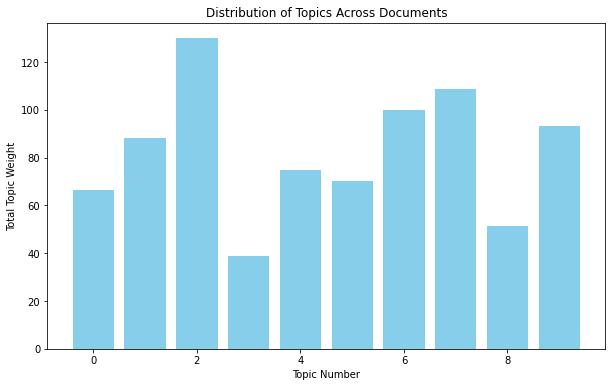

In [ ]:
# Transform the documents into topic distributions
document_topics = nmf_model.transform(tfidf)

# Sum the topic weights across all documents
topic_distribution = np.sum(document_topics, axis=0)

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(range(len(topic_distribution)), topic_distribution, color='skyblue')
plt.xlabel('Topic Number')
plt.ylabel('Total Topic Weight')
plt.title('Distribution of Topics Across Documents')
plt.show()

As we can see, the values with the lowest topic weight are the topics that did not match our themes, i.e. topic 3 and topic 8.

We can take a look at how our model clustered topics using TSNE (t-Distributed Stochastic Neighbor Embedding), a statistical method for visualizing high-dimensional data by reducing it to lower- dimensional spaces. It provides a visual representation of how well-separated or cohesive our topics are.

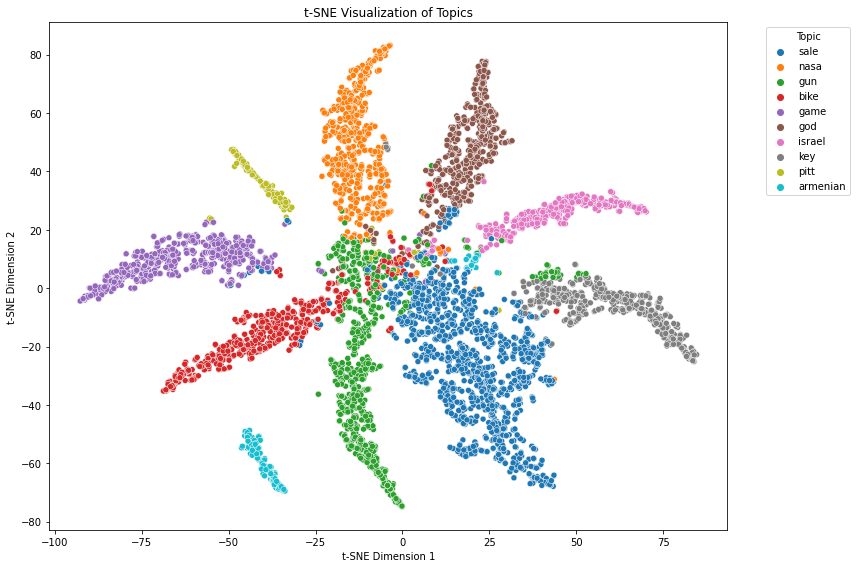

In [ ]:
# Define topic names based on your interpretation of the topics
topic_names = {index: topic for index, topic in enumerate(topics)}

# Transform the documents into topic distributions
document_topics = nmf_model.transform(tfidf)

# Assign a dominant topic to each document
dominant_topics = np.argmax(document_topics, axis=1)

# Replace numerical labels with topic names
dominant_topic_names = pd.Series(dominant_topics).map(topic_names)

# Reduce dimensions to 2D using t-SNE
tsne_model = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_values = tsne_model.fit_transform(document_topics)

# Create a DataFrame for plotting
tsne_df = pd.DataFrame({
    "Dimension 1": tsne_values[:, 0],
    "Dimension 2": tsne_values[:, 1],
    "Topic": dominant_topic_names
})

# Create a scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=tsne_df,
    x="Dimension 1",
    y="Dimension 2",
    hue="Topic",
    palette='tab10',
    legend='full'
)

# Customize plot
plt.title('t-SNE Visualization of Topics')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Most of the topics form distinct clusters in the t-SNE plot, indicating that the topics are reasonably well-separated in the embedding space. "Game" (purple) and "God" (brown) form tight clusters, representing coherent groupings of documents. The sale cluster seems to be the biggest, which makes sense considering that it grouped sale and graphic together. Pitt appears to be very small, along with Armenian, suggesting that there aren't many documents that fall into these groups. There also seems to be a lot of overlap in the middle, which could result in incorrect clustering. The overlap between "Key" (gray), "Gun" (green), and "NASA" (orange) might reflect shared words or contexts in the documents. Topics like "Armenian" (cyan) and "Pitt" (yellow) are tightly packed, suggesting high coherence and similarity among documents in these topics. Topics like "Gun" (green) and "Sale" (blue) are more spread out, indicating that the documents assigned to these topics are more diverse and less well-defined. "NASA" (orange) and "God" (brown) are relatively close, which may reflect some contextual overlap, perhaps due to discussions about space and philosophy. A few points appear scattered outside the main clusters (e.g., lone points near the middle or periphery). These could represent noisy documents that do not fit well into any topic or documents with mixed themes that overlap multiple topics.

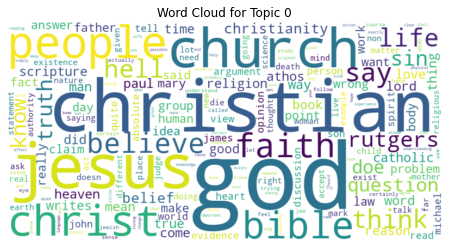

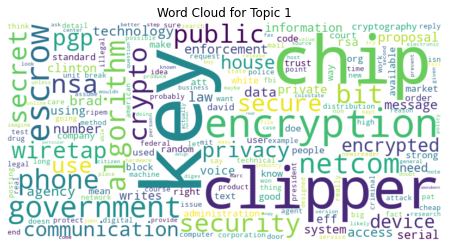

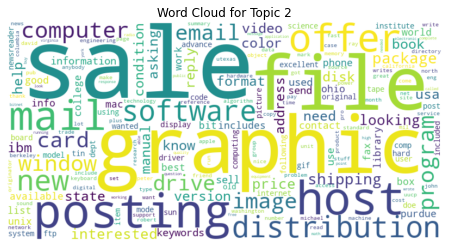

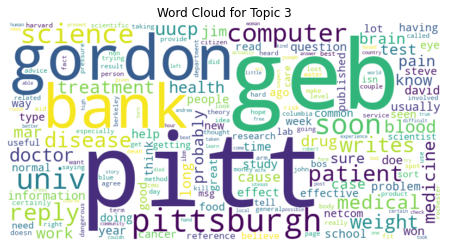

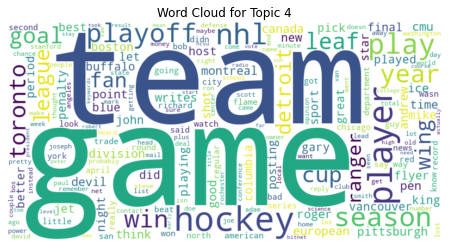

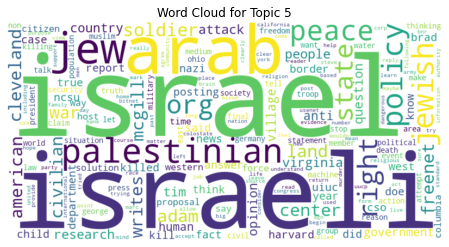

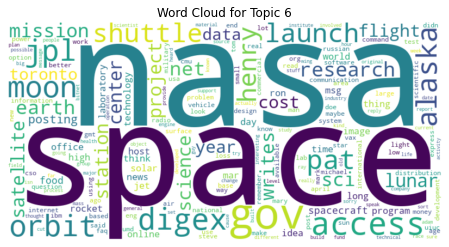

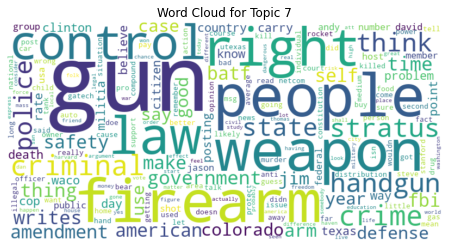

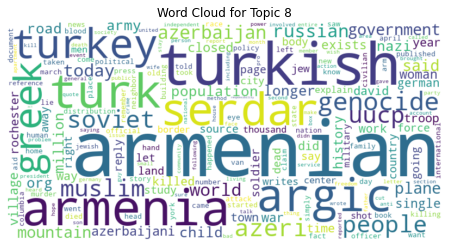

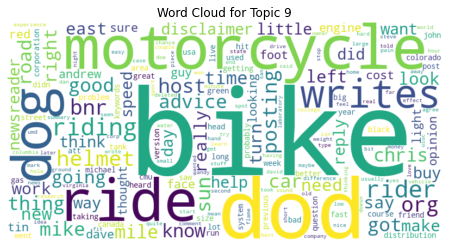

In [ ]:
# Generate a word cloud for each topic
for idx, topic in enumerate(nmf_model.components_):
    # Create a dictionary of words and their probabilities
    word_freq = {terms[i]: topic[i] for i in range(len(terms))}
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

    # Plot the word cloud
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Topic {idx}")
    plt.show()

In [ ]:
# Let's say we want the topic distribution for the first document (index 0)
document_index = 0
document_topics = W[document_index]  # Get topic weights for this document

# Identify the dominant topic for this document
dominant_topic = np.argmax(document_topics)

print(f"Document #{document_index + 1} dominant topic: Topic {dominant_topic + 1}")
print(f"Topic Distribution for Document #{document_index + 1}:")
for topic_idx, weight in enumerate(document_topics):
    print(f"Topic {topic_idx + 1}: {weight:.4f}")

# Print the top words for the dominant topic to understand its meaning
top_word_indices = H[dominant_topic].argsort()[-5:]  # Top 10 words for the dominant topic
print(f"\nTop 5 words for Dominant Topic {dominant_topic + 1}:")
print(" ".join([feature_names[i] for i in top_word_indices]))
print(f"\nActual Newsgroup:")
print(newsgroup_df.iloc[document_index]["newsgroup"])
print(f"\nDocument Content:")
print(newsgroup_df.iloc[document_index]["document"])

Document #1 dominant topic: Topic 3
Topic Distribution for Document #1:
Topic 1: 0.0002
Topic 2: 0.0511
Topic 3: 0.0576
Topic 4: 0.0054
Topic 5: 0.0110
Topic 6: 0.0000
Topic 7: 0.0013
Topic 8: 0.0014
Topic 9: 0.0035
Topic 10: 0.0303

Top 5 words for Dominant Topic 3:
host posting file graphic sale

Actual Newsgroup:
comp.graphics

Document Content:
From: jgreen@amber (Joe Green)
Subject: Re: Weitek P9000 ?
Organization: Harris Computer Systems Division
Lines: 14
Distribution: world
NNTP-Posting-Host: amber.ssd.csd.harris.com
X-Newsreader: TIN [version 1.1 PL9]

Robert J.C. Kyanko (rob@rjck.UUCP) wrote:
> abraxis@iastate.edu writes in article <abraxis.734340159@class1.iastate.edu>:
> > Anyone know about the Weitek P9000 graphics chip?
> As far as the low-level stuff goes, it looks pretty nice.  It's got this
> quadrilateral fill command that requires just the four points.

Do you have Weitek's address/phone number?  I'd like to get some information
about this chip.

--
Joe Green				Harr

Since we know the labels for the themes already, we will compare our themes to the actual themes. Since we were able to correctly extract 8 out of the 10 themes, our accuracy cannot go higher than 80%.

In [ ]:
topics

['god',
 'key',
 'sale',
 'pitt',
 'game',
 'israel',
 'nasa',
 'gun',
 'armenian',
 'bike']

In [ ]:
# Step 3: Assign topics to each document
newsgroup_df["Dominant Topic"] = W.argmax(axis=1)

# Group and reshape the data
grouped = newsgroup_df.groupby(["newsgroup", "Dominant Topic"]).count()["document"].reset_index()
pivoted = grouped.pivot(index="newsgroup", columns="Dominant Topic", values="document").fillna(0)

# Generate the interactive chart
fig = go.Figure()

# Add one bar trace for each topic
for topic in pivoted.columns:
    fig.add_trace(
        go.Bar(
            x=pivoted.index,
            y=pivoted[topic],
            name=f"Topic {topic}",
            visible=(topic == 0)  # Show only Topic 0 by default
        )
    )

# Add dropdown for interactivity
buttons = [
    dict(
        label=f"Topic {topic + 1}",
        method="update",
        args=[
            {"visible": [i == topic for i in range(len(pivoted.columns))]},
            {"title": f"Documents per Newsgroup for Topic {topic}"}
        ]
    )
    for topic in pivoted.columns
]

fig.update_layout(
    updatemenus=[dict(active=0, buttons=buttons)],
    title="Documents per Newsgroup by Topic",
    xaxis_title="Newsgroup",
    yaxis_title="Number of Documents",
    barmode="group"
)

# Show the interactive plot
fig.show()


#### Topic Diversity

Topic diversity measures how distinct the topics are from each other, based on their overlap or similarity.

"The more diverse the resulting topics are, the higher will be the coverage of the various aspects of the analyzed corpus. It is therefore important to also obtain topics that are different from each other (rather than just considering how much coherent the topics are)." -Silvia Terragni (https://github.com/silviatti/topic-model-diversity)

In [ ]:
top_ten_labels = H.argsort(axis=1)[:,-10:]
nmf_topics_output = dict()
nmf_topics_output['topics'] = [[feature_names[i] for i in x] for x in top_ten_labels]

In [ ]:
metric = TopicDiversity(topk=10) # Initialize metric
topic_diversity_score_nmf_18 = metric.score(nmf_topics_output) # Compute score of the metric
topic_diversity_score_nmf_18

0.98

#### Residual Score (NMF only)

"Residuals are differences between the observed and predicted values of the data. A residual of 0 means the topic perfectly approximates the text of the article, so the lower the better.

To calculate the residual you can take the Frobenius norm (square root of the sum of the absolute squares of its elements) of the tf-idf weights (A) minus the dot product of the coefficients of the topics (H) and the topics (W). We can then get the average residual for each topic to see which has the smallest residual on average." - https://freedium.cfd/https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45
<br><br><br>
How well do the topics approximate the original weights of the tfidf matrix for each document?
Averaged across topics, can get the sense of how good of an approximator each topic is.

Residual$[x_i]$$\norm{x_i - W_i \dot H}_F$ where document $x_i \in$ documents $X$, $W_i$ is row i of the Document-topic matrix and $H$ is the Topic-term matrix    

In [ ]:
# For each document calculate the difference between the original tfidf weights and those predicted
# by multiplying W and H for that specific row.
# Cell Source: https://freedium.cfd/https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45
def do_residual(tfidf, W, H):
    residuals = np.zeros(tfidf.shape[0])
    for row in range(tfidf.shape[0]):
        # 'fro' here means we are using the Frobenium norm as the distance metric
        residuals[row] = np.linalg.norm(tfidf[row, :] - W[row, :].dot(H), 'fro')
    return residuals

residuals = do_residual(tfidf, W, H)
residuals

array([0.95825797, 0.98622874, 0.95352704, ..., 0.98286569, 0.96884721,
       0.98304729])

In [ ]:
np.mean(residuals)

0.937804481753483

Text(0.5, 1.0, 'Average Residual per Document by Main Topic')

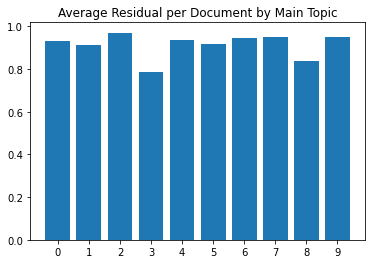

In [ ]:
residuals_by_topic = pd.Series(residuals).groupby(np.argmax(W, axis=1)).mean()
plt.bar(x=residuals_by_topic.index, height=residuals_by_topic.values)
plt.xticks(residuals_by_topic.index)
plt.title("Average Residual per Document by Main Topic")

Residuals are nearly indistinguishable by visualization.

In [ ]:
residuals_by_topic.sort_values(ascending=False)

2    0.970285
7    0.949328
9    0.948977
6    0.946627
4    0.937936
0    0.930819
5    0.916385
1    0.912481
8    0.838199
3    0.784864
dtype: float64

Topic 1 has the lowest residual while topic 2 has the highest.

#### "Expert" Manual Evaluation

Since relevance is difficult to interpret without a baseline, we compare the two for quality below by inspecting sets of training instances.

In [ ]:
chosen_topic_1 = np.random.choice(np.array(range(tfidf.shape[0]))[np.argmax(W, axis=1)==1], size=5, replace=False)
display([feature_names[i] for i in H[1].argsort()[-10:]])
for i, content in newsgroup_df['document'].iloc[chosen_topic_1].items(): display((i, content))
chosen_topic_2 = np.random.choice(np.array(range(tfidf.shape[0]))[np.argmax(W, axis=1)==2], size=5, replace=False)
display([feature_names[i] for i in H[2].argsort()[-10:]])
for i, content in newsgroup_df['document'].iloc[chosen_topic_2].items(): display((i, content))

['crypto',
 'phone',
 'netcom',
 'algorithm',
 'government',
 'escrow',
 'encryption',
 'clipper',
 'chip',
 'key']

(1787,
 'From: tuinstra@signal.ece.clarkson.edu.soe (Dwight Tuinstra)\nSubject: (new) reason for Clipper alg\'m secrecy\nReply-To: tuinstra@signal.ece.clarkson.edu.soe\nOrganization: Sun Microsystems, Inc.\nLines: 38\nNntp-Posting-Host: signal.ece.clarkson.edu\n\n[Apologies for not posting to alt.clipper, or whatever, but it seems it\nmay not be in the newsfeed here.]\n\nThere may be another reason (good from NSA\'s point of view, horrible\nfrom everyone else\'s) why the algorithm/chip design might be secret.\n\nFirst, note that the "experts" will only look at "details", and of just \nthe algorithm:\n\n    In addition, respected experts from outside the\n    government will be offered access to the confidential details of\n    the algorithm to assess its capabilities and publicly report\n    their findings.\n\nWhy not the chip design?  Well, here\'s the possiblity:  in addition to\nencryption, the chip pre-processes voice signals to make them easier\nto analyze/transcribe electronicall

(4087,
 'From: amolitor@nmsu.edu (Andrew Molitor)\nSubject: Re: Once tapped, your code is no good any more.\nOrganization: Department of Mathematical Sciences\nLines: 38\nDistribution: na\nNNTP-Posting-Host: moink.nmsu.edu\n\nIn article <tcmayC5M2xv.JEx@netcom.com>\n\ttcmay@netcom.com (Timothy C. May) writes:\n>\n>But is it any worse than the current unsecure system? It becomes much\n>worse, of course, if the government then uses this "Clinton Clipper"\n>to argue for restrictions on unapproved encryption. (This is the main\n>concern of most of us, I think. The camel\'s nose in the tent, etc.)\n>\n\n\tNot to pick on Mr. May in particular, of course, but isn\'t this\nkind of the domino theory? When one little country falls, its neighbor\nwill surely follow, and before you know it, we\'re all mining salt\nin Siberia for not turning in our Captain Crunch Secret Decoder Rings.\n\n\tSurely the hypothesis relying on the least wild assumptions is\nto take this at face value. Our lads at the fo

(7053,
 'From: paul@charon.gsfc.nasa.gov (Paul Olson)\nSubject: Re: White House Public Encryption Management Fact Sheet\nNews-Software: VAX/VMS VNEWS 1.41    \nOrganization: Mission Operations and Data Systems\nDistribution: na\nLines: 44\n\nIn article <1qnav4$r3l@transfer.stratus.com>, cme@ellisun.sw.stratus.com (Carl Ellison) writes...\n>In article <C5LGAz.250@dove.nist.gov> clipper@csrc.ncsl.nist.gov (Clipper Chip Announcement) writes:\n> \n>>Further, the Attorney General\n>>shall utilize funds from the Department of Justice Asset Forfeiture\n>>Super Surplus Fund to effect this purchase.\n> \n>Talk about adding insult to injury ... \n> \n>I, for one, believe that the use of civil forfeiture should be abolished by\n>a decent administration, not continued.  Instead, it looks like that\n>ill-gotten gain will be used to help pay for wiretap equipment.\n\nI wholeheartedly agree.  Knowing that WE have let our law enforcement agencies\nseize our property against the Fifth Amendment of OUR 

(6825,
 'From: rdippold@qualcomm.com (Ron "Asbestos" Dippold)\nSubject: Re: clipper chip --Bush did it\nOriginator: rdippold@qualcom.qualcomm.com\nKeywords: Big Bubba Is Watching!\nNntp-Posting-Host: qualcom.qualcomm.com\nOrganization: Qualcomm, Inc., San Diego, CA\nDistribution: na\nLines: 13\n\njohng@ecs.comm.mot.com (John Gilbert) writes:\n>This must have been in the works for some time.  The Bush administration must\n>have been working on it for quite a while.  --Clinton simply took the credit (or\n>blame, depending on how you look at it).\n\nAnd the initiative for actual implementation.  Clinton is not just an\ninnocent bystander here - They didn\'t just slap his name on it without\nconsulting him.  What exactly is his extensive history of individual\nrights advocacy that people are assuming he really has nothing to do\nwith this?  He just went back on his pledge to cut the espionage\nbudget, and is now asking for more money than even Bush wanted.\n-- \nI\'ve left my body to scien

(3232,
 'From: barrett@lucy.ee.und.ac.za (Alan Barrett)\nSubject: Re: White House Public Encryption Management Fact Sheet\nOrganization: Elec. Eng., Univ. Natal, Durban, S. Africa\nLines: 19\nDistribution: inet\nNNTP-Posting-Host: lucy.ee.und.ac.za\n\nIn article <C5LGAz.250@dove.nist.gov>,\nclipper@csrc.ncsl.nist.gov (Clipper Chip Announcement) writes:\n> Distribution: na\n\nNo thanks.  This topic is of interest to a much wider audience.\n\n> In making this decision, I do\n> not intend to prevent the private sector from developing, or the\n> government from approving, other microcircuits or algorithms that\n> are equally effective in assuring both privacy and a secure key-\n> escrow system.\n\n"In making this decision, I intend to prevent the private sector from\ndeveloping, except with the government\'s approval, other microcircuits\nor algorithms that are more effective in assuring privacy."\n\n--apb\nAlan Barrett, Dept. of Electronic Eng., Univ. of Natal, Durban, South Africa\nRFC82

['software',
 'new',
 'distribution',
 'offer',
 'mail',
 'host',
 'posting',
 'file',
 'graphic',
 'sale']

(7262,
 'From: ma225121@umbc.edu (Jonas Schlein)\nSubject: Olivetti XT\nOrganization: University of Maryland, Baltimore County Campus\nLines: 8\nDistribution: world\nNNTP-Posting-Host: umbc8.umbc.edu\nX-Auth-User: ma225121\n\nI am selling an AT&T XT compatible. It comes with a green screen CGA monitor,\n360k 5.25" Floppy Drive, and a 20 Megabyte Hard Drive.\n\nYou would think it was brand new from the condition it\'s in.\n\nAsking price is $150 + Shipping.\n\nReply via E-Mail if interested.\n')

(5313,
 "From: bdolson@casbah.acns.nwu.edu (Brian David Olson)\nSubject: For Sale: IBM Wheelwriter 6\nNntp-Posting-Host: elvex34.acns.nwu.edu\nOrganization: Northwestern University\nLines: 11\n\nI just won an IBM Wheelwriter 6 typewriter in a raffle here on campus. \nSince I have a nice computer, and really need the cash, I'm putting it up\nfor sale.  I have an offer from a local reseller for $250.  Best offer\nabove that plus shipping.\n\n...brian\n\nNorthwestern University - Economics & International Studies\nb-olson@nwu.edu                      Brian David Olson\nbdolson@casbah.acns.nwu.edu   bdolson@cica.es\nbdolson@merle.acns.nwu.edu    bdolson@sevaxu.cica.es\n")

(4745,
 'From: asalerno@cbnewsm.cb.att.com (antonio.j.salerno..jr)\nSubject: DoD Books\nOrganization: AT&T\nDistribution: na\nLines: 18\n\nAnyone around here read this yet?\nDoes Anita have a number?\n\n>>   Title: Software measurement for DoD systems : recommendations for initial \n>>          core measures / Anita D. Carleton, ... [et al.].\n>> Subject: Software engineering.; Computer programming management.\n>>  Author: Carleton, Anita D.\n>>  Author: Carnegie-Mellon University. Software Engineering Institute.\n>>    Publ: Pittsburgh, Pa. : Carnegie Mellon University, Software Engineering \n>>          Institute, 1992. 53 p.\n\n\nTony\n-- \n=-=-= These opinions are nothing but my own, and I may not even want them =-=-=\nAntonio Salerno            "The heart, the liver, the spleen, the pancreas. All\nantonio.j.salerno@att.com   these miraculous organs work in _total_darkness_!"\n=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- - David Letterman -=-=-=-=-=\n')

(2878,
 'From: radley@gibbs.oit.unc.edu (Keith Radley)\nSubject: Misc Electronic Eqpt\nSummary: electronics for sale\nNntp-Posting-Host: gibbs.oit.unc.edu\nOrganization: University of North Carolina at Chapel Hill\nDistribution: usa\nLines: 20\n\n \nPanasonic KX-T3000H, Combo black cordless & speaker phone all in one.\n new- $160, now- $100 + shipping OBO.\n \nCurtis Mathes VHS VCR Remote included and it works with universal remotes.\n Works great but I replaced it with a Stereo VCR.\n paid $300 years ago, will sell for $125 delivered OBO.\n \nRadio Shack stereo amp.  2 inputs, tone, and left and right volume.  Speakers\n not included.  $20 plus shipping.\n \nIf you are interested in either of the above mail me at\n radley@gibbs.out.unc.edu.\n\n        _\n    _  //       Major: Computer Science              /<eith Radley\n    \\\\//        Minor:     English              Radley@gibbs.oit.unc.edu\n     \\/      Computer:   AMIGA 3000           University of North Carolina\n\n\n')

(9143,
 'From: jlz@sonata.cc.purdue.edu (Jian Zhen)\nSubject: computer stuff for sale\nOrganization: Purdue University\nLines: 93\n\n                      COMPUTER HARDWARE\n  \t   ( all are working fine last time checked ) \n\nTandy 360k external floppy drive with cable (hardly used)\n                                    ..................... $70  \n\n\n-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-\n\n\n                       SOFTWARE\n\t  ( all software include original manual  ) \n\t  ( some even with registeration card.    )\n\nPer$onal Financial Accountant \n    - financial statements\n    - balance sheet\n    - income & expense\n    - etc ...                   ......................... $8\n\nAinsworth Keyboard Trainer (typing teacher) ............. $8\n\nEasy Working Tri-Pack (includes following ... )\n   - Filer -- database to store all kinds of information\n   - Planner -- Spreadsheet \n   - Writer -- an easy to use word processor\n   - great for simple cal

Both topics seem to be representative of the randomly chosen instances best explained by that topic.

#### Coherence Score for NMF

Coherence score measures the relative distance between words within a topic.

Begin Sourced Code. This code was adapted for our use but heavily influenced by the following:

Source: https://github.com/derekgreene/topic-model-tutorial/blob/master/3%20-%20Parameter%20Selection%20for%20NMF.ipynb

<b>Build a Word Embedding</b>

To select the number of topics, here we will use a topic coherence measure called TC-W2V. This measure relies on the use of a word embedding model constructed from our corpus. So in this step we will use the Gensim implementation of Word2Vec to build a Word2Vec model based on our collection of news articles.

In [ ]:
# #First, we need to define a class that will generate documents in a form that can be consumed by Gensim's Word2Vec implementation:

# class TokenGenerator:
#     def __init__(self, documents, stopwords):
#         self.documents = documents
#         self.stopwords = stopwords
#         self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

#     def __iter__(self):
#         print("Building Word2Vec model ...")
#         for doc in self.documents:
#             tokens = []
#             for tok in self.tokenizer.findall( doc ):
#                 if tok in self.stopwords:
#                     tokens.append( "<stopword>" )
#                 elif len(tok) >= 2:
#                     tokens.append( tok )
#             yield tokens

In [ ]:
# # Now build a Skipgram Word2Vec model from all documents in the input file using Gensim:

# raw_documents = newsgroup_df['processed_documents']
# custom_stop_words = stop_words

# docgen = TokenGenerator(raw_documents, custom_stop_words)
# # The model has 500 dimensions, the minimum document-term frequency is 20
# w2v_model = Word2Vec(docgen, vector_size=500, min_count=20, sg=1)

# # Save for later use, so that we do not need to rebuild it:
# w2v_model.save("w2v-model.bin")

# print("Model has %d terms" % len(w2v_model.wv.key_to_index))

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Model has 6442 terms


In [ ]:
# To re-load this model, run
w2v_model = Word2Vec.load("w2v-model.bin")

Once we have our Word2vec model, we can use it as an external source of information to validate the topic models against. To do this, we will implement a simple version of the TC-W2V coherence measure.


In [ ]:
# We use the Word2vec model to calculate coherence scores for each of these models.
# We will define this coherence score as follows:

def calculate_coherence(w2v_model, term_rankings):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            try: # sometimes a term NMF identified may not have been identified by w2v
                pair_scores.append( w2v_model.wv.similarity(pair[0], pair[1]) )
            except:
                None
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

#We also define a function to get the topic descriptor (i.e. list of top terms) for each topic:

def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

In [ ]:
def do_coherence(k, W, H, terms=feature_names):
    """Generates a final coherence score for a NMF model"""
    # where k is number of topics

    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    global temp_top_terms
    temp_top_terms = term_rankings
    curr_coherence = calculate_coherence( w2v_model, term_rankings )
    print("K=%02d: Coherence=%.4f" % ( k, curr_coherence ) )
    return curr_coherence

In [ ]:
do_coherence(10, W, H)

K=10: Coherence=0.4353


0.43531654487157034

end sourced code

### NMF - Automatic Topic Number

In practice, a model will not know a-priori the true number of topics in a set, so coherence score can be used as a measure to choose the best topic model across multiple numbers of topics.

In [ ]:
# Create a list of the topic numbers we want to try
topic_nums = np.arange(10, 30, 2)
coherence_scores = dict()
nmf_models = dict()

for k in topic_nums:
    curr_W, curr_H, curr_model = do_nmf(tfidf, k)
    nmf_models[k] = (curr_W, curr_H)
    coherence_scores[k] = do_coherence(k, curr_W, curr_H)

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores.values()))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_num_topics, coherence_scores[best_num_topics])

K=10: Coherence=0.4353
K=12: Coherence=0.4408
K=14: Coherence=0.4298
K=16: Coherence=0.4164
K=18: Coherence=0.4223
K=20: Coherence=0.4137
K=22: Coherence=0.4165
K=24: Coherence=0.4171
K=26: Coherence=0.4001
K=28: Coherence=0.4126
12 0.4408179685068145


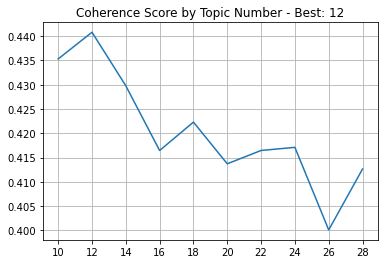

In [ ]:
plt.plot(topic_nums, coherence_scores.values())
plt.title("Coherence Score by Topic Number - Best: {}".format(best_num_topics))
plt.grid(True)
plt.xticks(topic_nums)
plt.show()

In [ ]:
# manually selected had residual of 0.937
np.mean(do_residual(tfidf, nmf_models[12][0], nmf_models[12][1]))

0.9321538958631735

The model chosen by hyperparameter optimization on coherence would have 12 parameters. This has very similar residual as the manual model with 10 parameters.

### BERTopic

We implement bert using the implementation by Maarten Grootendorst. We restrict the number of topics to 10 to be able to digest them and compare better with NMF.

Uncomment the below to train BERTopic, otherwise load later on.

In [153]:
newsgroup_df = newsgroup_df.reset_index().drop(columns="index")

In [154]:
# Pre-calculate embeddings
data = newsgroup_df["processed_documents"]

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(data, show_progress_bar=True)

Batches:   0%|          | 0/184 [00:00<?, ?it/s]

In [156]:
#method for dimensionality reduction
umap_model = UMAP.UMAP(#n_neighbors=50,
                  #min_dist=0.5,
                  #metric='cosine',
                  random_state=35)

In [155]:
#higherarchial clustering method
hdbscan_model = HDBSCAN(min_cluster_size=50,
                        #min_samples=30
                       )

In [157]:
#vectorizer to create matrix from corpus
vectorizer_model = TfidfVectorizer(min_df=1, max_df=0.95, max_features=1000)

In [159]:
topic_model = BERTopic(

  # Pipeline models|
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  vectorizer_model=vectorizer_model,

  # Hyperparameters
  top_n_words = 10,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(data, embeddings)

2024-12-03 08:02:15,487 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-12-03 08:02:27,484 - BERTopic - Dimensionality - Completed ✓
2024-12-03 08:02:27,487 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-12-03 08:02:27,637 - BERTopic - Cluster - Completed ✓
2024-12-03 08:02:27,646 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-12-03 08:02:28,574 - BERTopic - Representation - Completed ✓


#### Bertopic Evaluation - Manual "Expert" Evaluation

In [160]:
# Show topics
topic_model.get_topic_info()

Topic  Count                              Name  \
0     -1     61       -1_rider_ufl_cunixb_freedom   
1      0   1805    0_image_nasa_graphic_satellite   
2      1   1140  1_encryption_gun_clipper_firearm   
3      2    612         2_bike_dod_bmw_motorcycle   
4      3    606         3_hockey_nhl_team_playoff   
5      4    571            4_geb_pitt_msg_disease   
6      5    564       5_jesus_church_bible_christ   
7      6    335         6_israeli_israel_arab_jew   
8      7    164   7_armenian_turkish_armenia_turk   

                                      Representation  \
0  [rider, ufl, cunixb, freedom, min, muslim, mil...   
1  [image, nasa, graphic, satellite, jpeg, orbit,...   
2  [encryption, gun, clipper, firearm, escrow, ch...   
3  [bike, dod, bmw, motorcycle, ride, helmet, rid...   
4  [hockey, nhl, team, playoff, player, play, sea...   
5  [geb, pitt, msg, disease, dyer, patient, gordo...   
6  [jesus, church, bible, christ, faith, sin, chr...   
7  [israeli, israel, arab, jew, lebanese, palesti...   
8  [armenian, turkish, armenia, turk, serdar, aze...   

                                 Representative_Docs  
0  [ravel udel samuel ross sam comic sale auction...  
1  [leech unc jon leech space faq mission schedul...  
2  [danny weitzner djw eff org inventing crypto p...  
3  [frank marvin contex frank perdicaro ride keyw...  
4  [golchowy alchemy chem utoronto gerald olchowy...  
5  [geb pitt gordon bank travel outside banglades...  
6  [pharvey quack kfu paul harvey sabbath admissi...  
7  [center policy research cpr igc apc org rejoin...  
8  [serum zuma uucp serdar argic cold blooded sla...

All of the topics are comprehensible. Most of the topics all capture ideas that we know were contained within the original datset, but some like "sunrise_sunset" and "geekdom" don't particularly match topics we'd imagine from the set.

#### Bertopic Evaluation - Visualization

In [162]:
#setting for below visualization
pio.renderers.default = "notebook"

In [164]:
data = newsgroup_df["processed_documents"]
classes = list(newsgroup_df["newsgroup"])
topics_per_class = topic_model.topics_per_class(data, classes=classes)

10it [00:01,  9.98it/s]


In [ ]:
topic_model.visualize_topics_per_class(topics_per_class, top_n_topics=10)

This interactive chart shows the original distributions of labels for documents assigned to each BERTopic generated topic. For example, the gun-related topic contains mostly documents from the gun and science category.

In [165]:
topic_model.visualize_topics()

#### BERTopic Evaluation - Predictive Utility

As seen in the previous visualizations, the topics generated by BERTopic don't map back nicely to the original categories. Therefore we can't use how well the model captured the original categories as a sanity check in this case.

#### BERTopic Evaluation - Coherence

In [166]:
def do_coherence_bertopic(bertopic_topics, terms=feature_names):
    """Generates a final coherence score for a NMF model"""
    # where k is number of topics

    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = bertopic_topics
    curr_coherence = calculate_coherence( w2v_model, term_rankings )
    print("K=%02d: Coherence=%.4f" % ( len(term_rankings), curr_coherence ) )
    return curr_coherence

In [167]:
#extract the topics from the trained model
bertopic_topics = np.array(list(topic_model.topic_representations_.values()))[:,:,0]

In [168]:
# Coherence Score
do_coherence_bertopic(bertopic_topics)

K=09: Coherence=0.5075


0.5075420030013279

#### BERTopic Evaluation - Diversity

In [169]:
# Topic Diversity
temp_df = dict()
temp_df['topics'] = bertopic_topics
metric.score(temp_df)

0.9888888888888889

### Comparison - NMF and BERTopic

| Measure              | NMF | BERTopic |
| :---------------- | :------: | :----: |
| Coherence        |   0.43   | 0.51 |
| Diversity           |   0.98   | 0.99 |